In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import emcee
from scipy.stats import multivariate_normal as mn
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
def gaussian(x, mu, var):
    return (2*np.pi*var)**(-.5) * np.exp(-.5*(x-mu)**2/var)

# Model

mean:
$$
\mu(\lambda, z) = \log_{10}(M_{\rm 0}) + G_z^\mu\log_{10}\left(\frac{1 + z}{1 + z_0}\right) + G_\lambda^\mu\log_{10}\left(\frac{\lambda}{\lambda_0}\right)
$$

In [8]:
def mu_logM_lambda(redshift, logrichness, mu0, G_z_mu, G_lambda_mu):
    return mu0 + G_z_mu*np.log10((1+redshift)/(1 + z_0)) + G_lambda_mu*(logrichness-np.log10(richness_0))

standard deviation:
$$
\sigma(\lambda, z) = \sigma_{\log_{10}M} + F_z^\sigma\log_{10}\left(\frac{1 + z}{1 + z_0}\right) + F_\lambda^\sigma\log_{10}\left(\frac{\lambda}{\lambda_0}\right)
$$

In [9]:
def sigma_logM_lambda(redshift, logrichness, sigma_mu0, F_z_sigma, F_lambda_sigma):
    return sigma_mu0 + F_z_sigma*np.log10((1+redshift)/(1 + z_0)) + F_lambda_sigma*(logrichness-np.log10(richness_0))

Conditional probability:
$$
P(\log_{10}M|\lambda, z) = \frac{1}{\sqrt{2\pi \sigma (\lambda, z)^2}}\exp{-\frac{1}{2}\left(\frac{\log_{10}M - \mu(\lambda, z)}{\sigma (\lambda, z)}\right)^2}
$$

In [10]:
def P(data, theta):
    r"""probability of observing the data knowing the value of theta"""
    mu0, G_z_mu, G_lambda_mu, sigma_mu0, F_z_sigma, F_lambda_sigma = theta
    logm200c, redshift, logrichness = data
    mu = mu_logM_lambda(redshift, logrichness, mu0, G_z_mu, G_lambda_mu,)
    sigma = sigma_logM_lambda(redshift, logrichness, sigma_mu0, F_z_sigma, F_lambda_sigma)
    return gaussian(logm200c, mu, sigma**2)

# Data

In [11]:
data_match = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/matched_redMaPPer_to_cosmodc2.pkl')
z_0 = np.mean(data_match['redshift_RedMapper'])
richness_0 = np.mean(data_match['richness_RedMapper'])
logm200c = np.log10(data_match['M200c_cosmoDC2'])
logrichness = np.log10(data_match['richness_RedMapper'])
redshift = data_match['redshift_RedMapper']
data_mcmc = [logm200c, redshift, logrichness]

In [12]:
len(data_match)

3777

Text(0.5, 0, '$\\log_{10}\\lambda$')

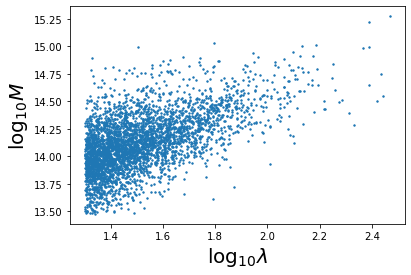

In [13]:
plt.scatter(logrichness, logm200c, s = 2)
plt.ylabel(r'$\log_{10}M$', fontsize = 20)
plt.xlabel(r'$\log_{10}\lambda$', fontsize = 20)

# Likelihood

Log-likelihood:
$$
\ln L_{\rm un-binned} = \sum_{i = 1} \ln P(\log_{10}M_{200c,i}|\lambda_i, z_i)
$$

In [14]:
def lnL(theta):
    p = P(data_mcmc, theta)
    return np.sum(np.log(p))

# MCMC

In [15]:
initial = [14.1,0.0,1,0.1,0.,0.]
pos = initial + 0.001 * np.random.randn(70, len(initial))
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL)
sampler.run_mcmc(pos, 500, progress=True);

  2%|▏         | 11/500 [00:01<00:57,  8.56it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 500/500 [00:59<00:00,  8.43it/s]


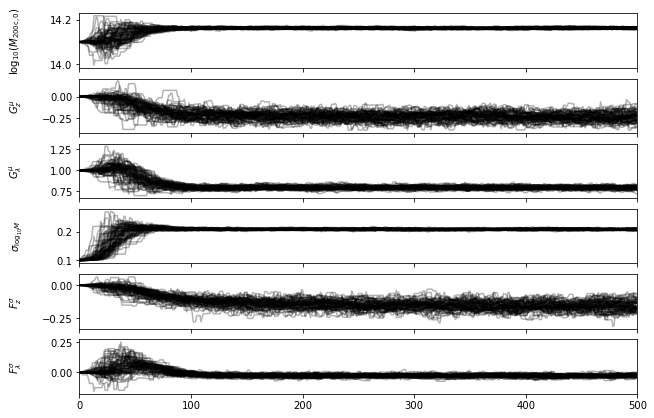

In [16]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
labels = [r'$\log_{10}(M_{\rm 200c,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$', r'$\sigma_{\log_{10}M}$', r'$F_z^\sigma$', r'$F_\lambda^\sigma$']
samples = sampler.get_chain()
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [17]:
flat_samples = sampler.get_chain(discard=300, thin=1,flat=True)

In [18]:
def mu_sigma_parameters(samples = None, labels = None):
    mu = {labels[i] : np.mean(samples[:,i]) for i in range(len(labels))}
    sigma = {labels[i] : np.std(samples[:,i]) for i in range(len(labels))}
    return mu, sigma

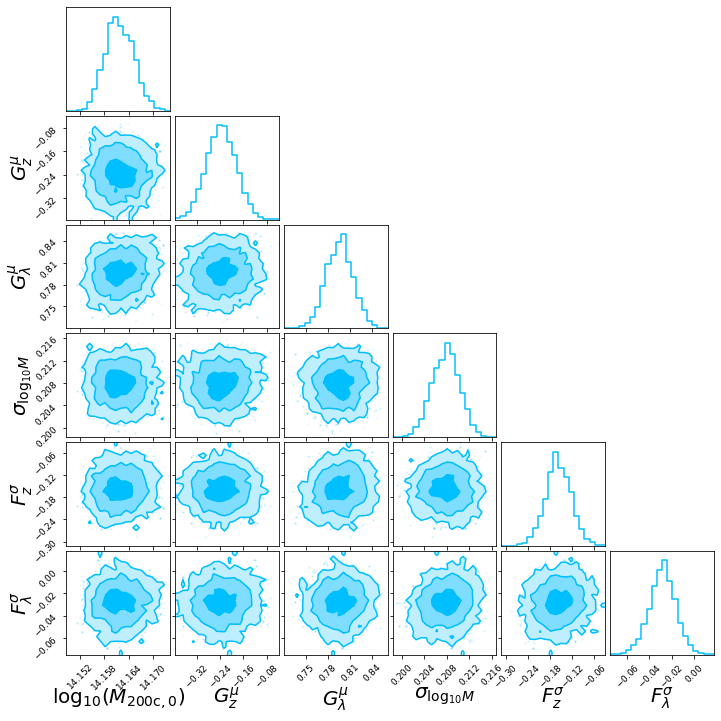

In [19]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
bins = 20
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 9)
fig = corner.corner(
    flat_samples,
    bins=bins, levels=(sigma1, sigma2, sigma3),
    fig = fig,
                        smooth1d=False,smooth=False,plot_datapoints=True,
                  fill_contours=True,labels = labels,
                         
    color='deepskyblue',
    label_kwargs={"fontsize": 20},
                  use_math_text=True,
                        plot_density=False,
                        max_n_ticks = 5,
);

# Best fit

In [20]:
mu_p, sigma_p = mu_sigma_parameters(samples = flat_samples, labels = labels)

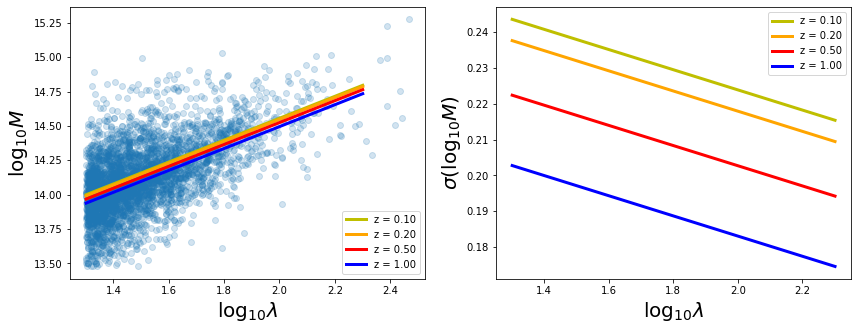

In [21]:
richness = np.linspace(20, 200, 100)
c = ['y', 'orange', 'r', 'b',]
fig, ax = plt.subplots(1, 2, figsize = (14,5))
ax[0].scatter(logrichness, logm200c, alpha = .2)
for i, z in enumerate([.1, .2, .5, 1]):
    mu = mu_logM_lambda(z, np.log10(richness), mu_p[r'$\log_{10}(M_{\rm 200c,0})$'], mu_p[r'$G_z^\mu$'], mu_p[r'$G_\lambda^\mu$'])
    sigma = sigma_logM_lambda(z, np.log10(richness), mu_p[r'$\sigma_{\log_{10}M}$'], mu_p[r'$F_z^\sigma$'], mu_p[r'$F_\lambda^\sigma$'])
    ax[0].plot(np.log10(richness), mu, c = c[i] , label = f'z = {z:.2f}', linewidth = 3)
    ax[0].legend()
    ax[1].plot(np.log10(richness), sigma, c = c[i] , label = f'z = {z:.2f}', linewidth = 3)
    ax[1].legend()
    ax[0].set_ylabel(r'$\log_{10}M$', fontsize = 20)
    ax[1].set_ylabel(r'$\sigma (\log_{10}M)$', fontsize = 20)
for i in range(2):
    ax[i].set_xlabel(r'$\log_{10}\lambda$', fontsize = 20)